# **Prediction of Nephropathy in Diabetic Patients**
---
Amira Ghina Nurfansepta (215150201111026)

## **Data Understanding**

### **Import Library**

In [58]:
pip install catboost

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingRegressor

import time
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Dataset**

In [61]:
df = pd.read_csv('/content/drive/MyDrive/Penelitian/data_pasien_diabetes.csv')
df.head()

,Name,Patient ID,Age,Creatinine,Semi-quantitative UACR,Urinary Creatinine,Quantitative UACR,Urinary Albumin
0,Adinda Maya Vidianti,11539264,20,0.91,NaN,68.3,194.20,103.27
1,Geraldi Satria,11561505,4,NaN,NaN,21.8,251.00,54.80
2,Yuni Setyowati,11561162,41,NaN,>=300,23.7,32.62,77.20
3,Ulfa,11224476,26,3.17,>=300,56.3,1110.90,62.49
4,Dalifa Fatimah,11323947,28,140.40,NaN,140.4,240.00,336.90


### **Number of Rows and Columns**

In [62]:
print("Number of rows =", df.shape[0])
print("Number of columns =", df.shape[1])

Number of rows = 500
Number of columns = 8


### **Dataset Information**

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    500 non-null    object 
 1   Patient ID              500 non-null    int64  
 2   Age                     500 non-null    int64  
 3   Creatinine              340 non-null    float64
 4   Semi-quantitative UACR  318 non-null    object 
 5   Urinary Creatinine      500 non-null    float64
 6   Quantitative UACR       495 non-null    float64
 7   Urinary Albumin         499 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 31.4+ KB


### **Descriptive Statistics**

**Numerical Column**

In [64]:
df.describe()

,Patient ID,Age,Creatinine,Urinary Creatinine,Quantitative UACR,Urinary Albumin
count,5.000000e+02,500.000000,340.000000,500.000000,495.000000,499.000000
mean,1.083715e+07,32.046000,1.413853,130.517820,1326.601111,865.203848
std,2.499121e+06,13.084276,7.638400,345.006133,6914.953062,2130.941434
min,2.081300e+05,3.000000,0.200000,0.300000,1.900000,0.550000
25%,1.135895e+07,22.000000,0.590000,42.500000,21.450000,15.450000
50%,1.149944e+07,29.000000,0.715000,79.100000,132.100000,87.700000
75%,1.154286e+07,39.000000,0.962500,139.275000,705.300000,503.200000
max,1.158394e+07,82.000000,140.400000,5022.200000,121845.570000,14267.400000


**Categorical Column**

In [65]:
df.describe(include='object')

,Name,Semi-quantitative UACR
count,500,318
unique,363,14
top,Adinda Maya Vidianti,<30
freq,6,77


### **Duplicated Data**

In [66]:
print("Number of duplicate data in the dataset:", df.duplicated().sum())

display(df[df.duplicated()])
df[df['Name'] == "Adinda Maya Vidianti"]

Number of duplicate data in the dataset: 1


,Name,Patient ID,Age,Creatinine,Semi-quantitative UACR,Urinary Creatinine,Quantitative UACR,Urinary Albumin
403,Adinda Maya Vidianti,11539264,20,0.82,NaN,76.5,132.1,101.0


,Name,Patient ID,Age,Creatinine,Semi-quantitative UACR,Urinary Creatinine,Quantitative UACR,Urinary Albumin
0,Adinda Maya Vidianti,11539264,20,0.91,NaN,68.3,194.2,103.27
92,Adinda Maya Vidianti,11539264,20,0.95,80,113.8,117.4,133.60
193,Adinda Maya Vidianti,11539264,21,0.73,150,115.7,121.3,140.40
336,Adinda Maya Vidianti,11539264,20,0.82,NaN,76.5,132.1,101.00
403,Adinda Maya Vidianti,11539264,20,0.82,NaN,76.5,132.1,101.00
469,Adinda Maya Vidianti,11539264,20,0.62,NaN,24.2,174.7,42.20


There is a duplication of data on Adinda Maya Vidianti, so it must be deleted.

### **Missing Value**

In [67]:
df.isna().sum()

Name                        0
Patient ID                  0
Age                         0
Creatinine                160
Semi-quantitative UACR    182
Urinary Creatinine          0
Quantitative UACR           5
Urinary Albumin             1
dtype: int64

There are many missing values in columns Creatinine and Semi-quantitative UACR, so imputation is necessary. In addition, there are few missing values in columns Quantitative UACR and Urinary Albumin, so they need to be dropped.

## **Data Preprocessing**

### **Remove Duplicated Data**

In [68]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

### **Drop Missing Value**

In [69]:
df = df.dropna(subset=['Urinary Albumin', 'Quantitative UACR'])
df.isna().sum()

Name                        0
Patient ID                  0
Age                         0
Creatinine                156
Semi-quantitative UACR    178
Urinary Creatinine          0
Quantitative UACR           0
Urinary Albumin             0
dtype: int64

### **Input Missing Value**

In [70]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

knn_imputer = KNNImputer(n_neighbors=2)
simple_imputer = SimpleImputer(strategy='most_frequent')

df_input = df.copy()
df_input['Creatinine'] = knn_imputer.fit_transform(df_input[['Creatinine']])
df_input['Semi-quantitative UACR'] = simple_imputer.fit_transform(df_input[['Semi-quantitative UACR']])
df_input.head()

,Name,Patient ID,Age,Creatinine,Semi-quantitative UACR,Urinary Creatinine,Quantitative UACR,Urinary Albumin
0,Adinda Maya Vidianti,11539264,20,0.910000,<30,68.3,194.20,103.27
1,Geraldi Satria,11561505,4,1.406627,<30,21.8,251.00,54.80
2,Yuni Setyowati,11561162,41,1.406627,>=300,23.7,32.62,77.20
3,Ulfa,11224476,26,3.170000,>=300,56.3,1110.90,62.49
4,Dalifa Fatimah,11323947,28,140.400000,<30,140.4,240.00,336.90


In [71]:
df_input.isna().sum()

Name                      0
Patient ID                0
Age                       0
Creatinine                0
Semi-quantitative UACR    0
Urinary Creatinine        0
Quantitative UACR         0
Urinary Albumin           0
dtype: int64

Missing values have been filled in df_input.

## **Exploratory Data Analysis**

### **Analysing The Features**

**Name**

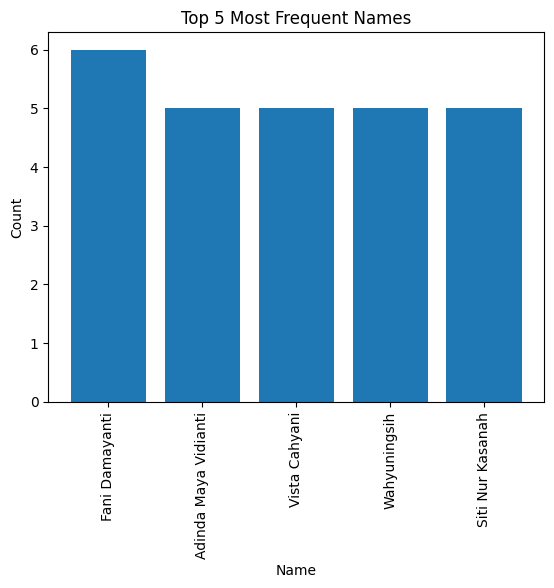

In [72]:
df_name = df['Name'].value_counts(ascending=False).reset_index()
df_name.columns = ['Name', 'Count']
df_name_head = df_name.head()

plt.bar(df_name_head['Name'], df_name_head['Count'])
plt.xlabel('Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Top 5 Most Frequent Names')
plt.show()

Patient with the most names in the dataset is Fani Damayanti, which is 6 times.

**Patients ID**

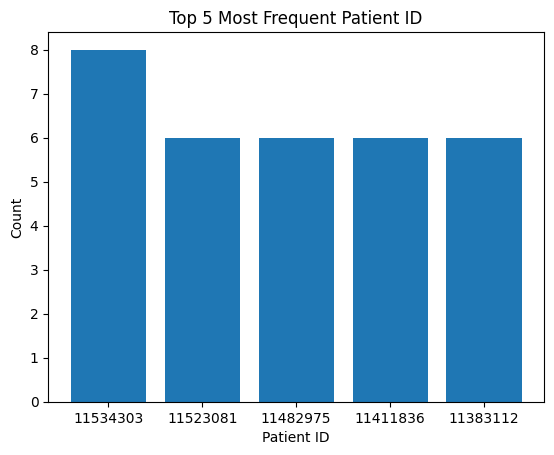

In [73]:
df_id = df['Patient ID'].value_counts(ascending=False).reset_index()
df_id.columns = ['Patient ID', 'Count']
df_id['Patient ID'] = df_id['Patient ID'].astype(str)
df_id_head = df_id.head()

plt.bar(df_id_head['Patient ID'], df_id_head['Count'])
plt.xlabel('Patient ID')
plt.ylabel('Count')
plt.title('Top 5 Most Frequent Patient ID')
plt.show()

In [74]:
display(df[df['Patient ID'] == 11534303])
df[df['Patient ID'] == 11523081]

,Name,Patient ID,Age,Creatinine,Semi-quantitative UACR,Urinary Creatinine,Quantitative UACR,Urinary Albumin
71,Meytabila,11534303,20,1.61,NaN,58.7,1536.40,902.0
129,Meytabilla,11534303,20,1.73,80,53.1,98.70,52.4
164,Meytabilla,11534303,21,1.59,80,178.7,90.00,160.8
187,Meytabilla,11534303,21,1.25,NaN,28.1,245.10,68.8
205,Meytabilla Mauludy,11534303,21,1.53,80,56.7,129.10,73.2
227,Meytabilla,11534303,21,1.30,80,120.0,89.17,107.0
236,Meytabilla Mauludy,11534303,20,2.05,>300,177.2,697.50,1235.6
321,Meytabilla Mauludy,11534303,20,1.31,>300,201.0,601.49,1209.0


,Name,Patient ID,Age,Creatinine,Semi-quantitative UACR,Urinary Creatinine,Quantitative UACR,Urinary Albumin
37,Wahyunignsih,11523081,28,0.38,>=300,149.7,267.2,399.8
77,Wahyunignsih,11523081,28,0.41,>= 300,144.0,509.5,733.7
151,Wahyuningsih,11523081,28,0.40,>=300,105.5,237.3,250.2
302,Wahyuningsih,11523081,28,0.31,>300,162.4,42.7,69.4
349,Wahyuningsih,11523081,28,0.36,>=300,30.2,753.2,227.7
378,Wahyuningsih,11523081,28,0.45,NaN,152.4,112.1,170.8


Patient with the most IDs in the dataset is not the same as the most names. This can occur due to incomplete or typo name writing.

**Age**

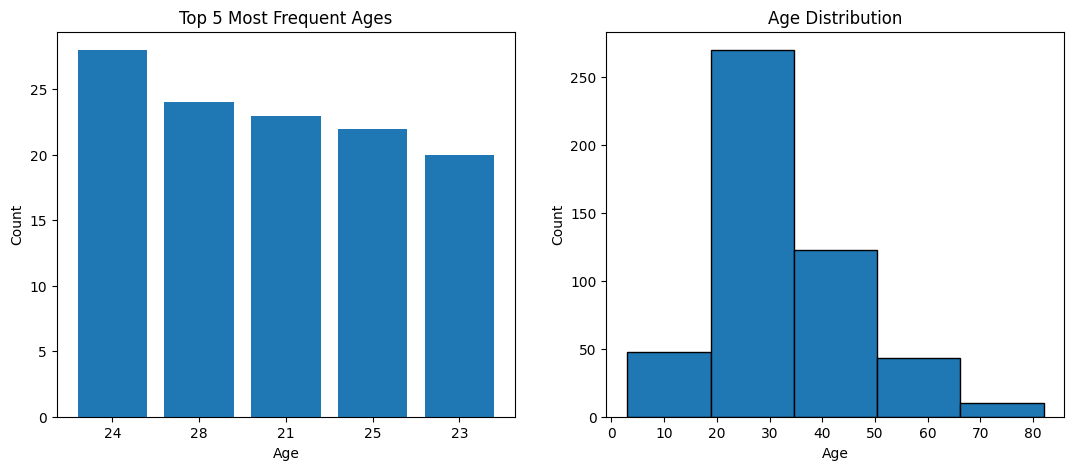

In [75]:
df_age = df['Age'].value_counts(ascending=False).reset_index()
df_age.columns = ['Age', 'Count']
df_age['Age'] = df_age['Age'].astype(str)
df_age_head = df_age.head()

f,ax=plt.subplots(1, 2, figsize=(13,5))
ax[0].bar(df_age_head['Age'], df_age_head['Count'])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')
ax[0].set_title('Top 5 Most Frequent Ages')
ax[1].hist(df['Age'], bins=5, edgecolor='k')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Count')
ax[1].set_title('Age Distribution')
plt.show()

Patients aged 24 are the most common patients in the dataset.

**Creatinine**

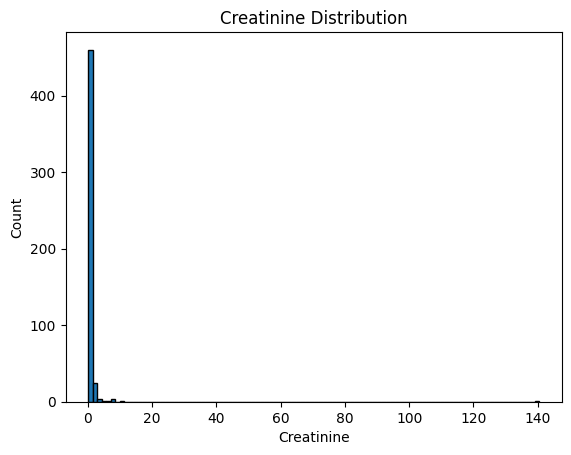

In [76]:
plt.hist(df_input['Creatinine'], bins=100, edgecolor='k')
plt.xlabel('Creatinine')
plt.ylabel('Count')
plt.title('Creatinine Distribution')
plt.show()

**Semi-quantitative UACR**

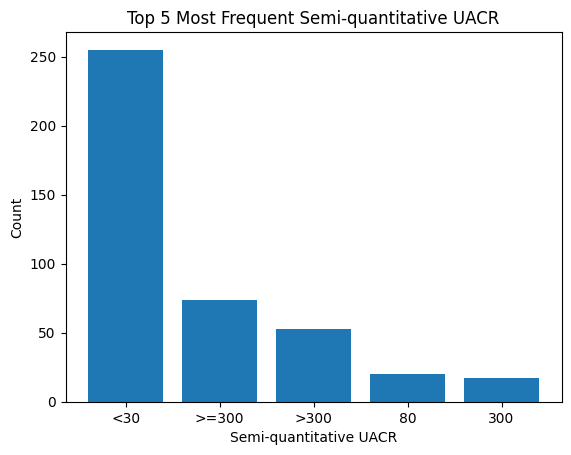

In [77]:
df_sq = df_input['Semi-quantitative UACR'].value_counts(ascending=False).reset_index()
df_sq.columns = ['Semi-quantitative UACR', 'Count']
df_sq_head = df_sq.head()

plt.bar(df_sq_head['Semi-quantitative UACR'], df_sq_head['Count'])
plt.xlabel('Semi-quantitative UACR')
plt.ylabel('Count')
plt.title('Top 5 Most Frequent Semi-quantitative UACR')
plt.show()

In [78]:
df_sq

,Semi-quantitative UACR,Count
0,<30,255
1,>=300,74
2,>300,53
3,80,20
4,300,17
5,<80,15
6,100,12
7,30,11
8,200,11
9,>=150,9


There are 13 classes of Semi-quantitative UACR and the most class in the dataset is <30.

### **Label Encoding**

In [79]:
label_encoder = preprocessing.LabelEncoder()

df_input['Semi-quantitative UACR'] = label_encoder.fit_transform(df_input['Semi-quantitative UACR'])

**Urinary Creatinine**

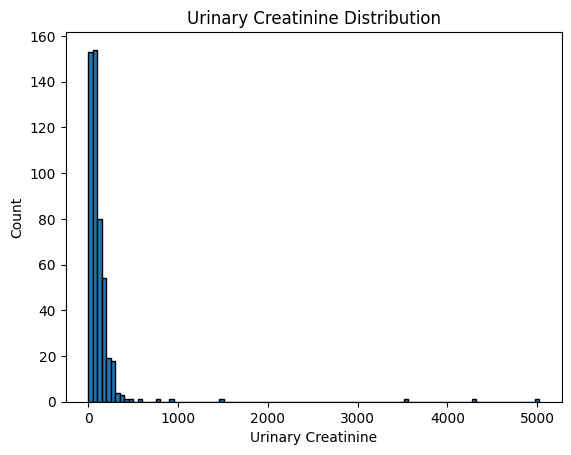

In [80]:
plt.hist(df['Urinary Creatinine'], bins=100, edgecolor='k')
plt.xlabel('Urinary Creatinine')
plt.ylabel('Count')
plt.title('Urinary Creatinine Distribution')
plt.show()

**Quantitative UACR**

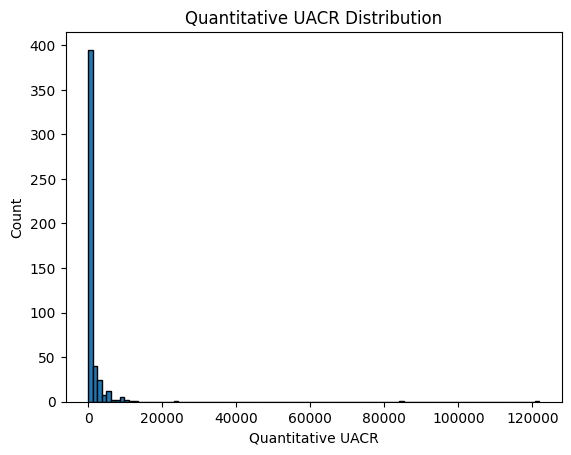

In [81]:
plt.hist(df['Quantitative UACR'], bins=100, edgecolor='k')
plt.xlabel('Quantitative UACR')
plt.ylabel('Count')
plt.title('Quantitative UACR Distribution')
plt.show()

**Urinary Albumin**

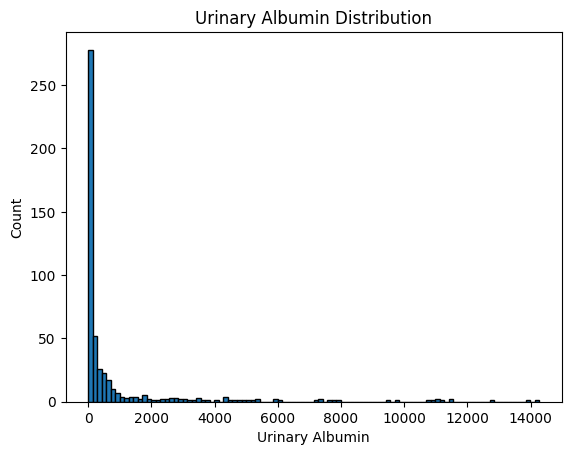

In [82]:
plt.hist(df['Urinary Albumin'], bins=100, edgecolor='k')
plt.xlabel('Urinary Albumin')
plt.ylabel('Count')
plt.title('Urinary Albumin Distribution')
plt.show()

### **Nephropaty**

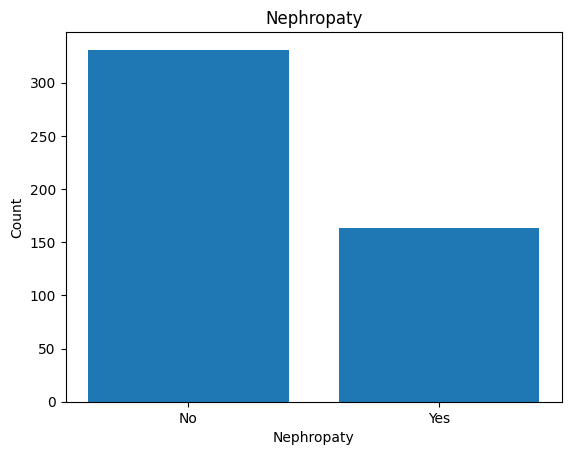

In [83]:
df_neph = pd.DataFrame({'Urinary Albumin': df['Urinary Albumin']})
df_neph['Nephropaty'] = df_neph['Urinary Albumin'].apply(lambda x: 'Yes' if x > 300 else "No")
df_neph = df_neph['Nephropaty'].value_counts(ascending=False).reset_index()
df_neph.columns = ['Nephropaty', 'Count']

plt.bar(df_neph['Nephropaty'], df_neph['Count'])
plt.xlabel('Nephropaty')
plt.ylabel('Count')
plt.title('Nephropaty')
plt.show()

More patients who did not have nephropathy than those who did.

### **Correlation**

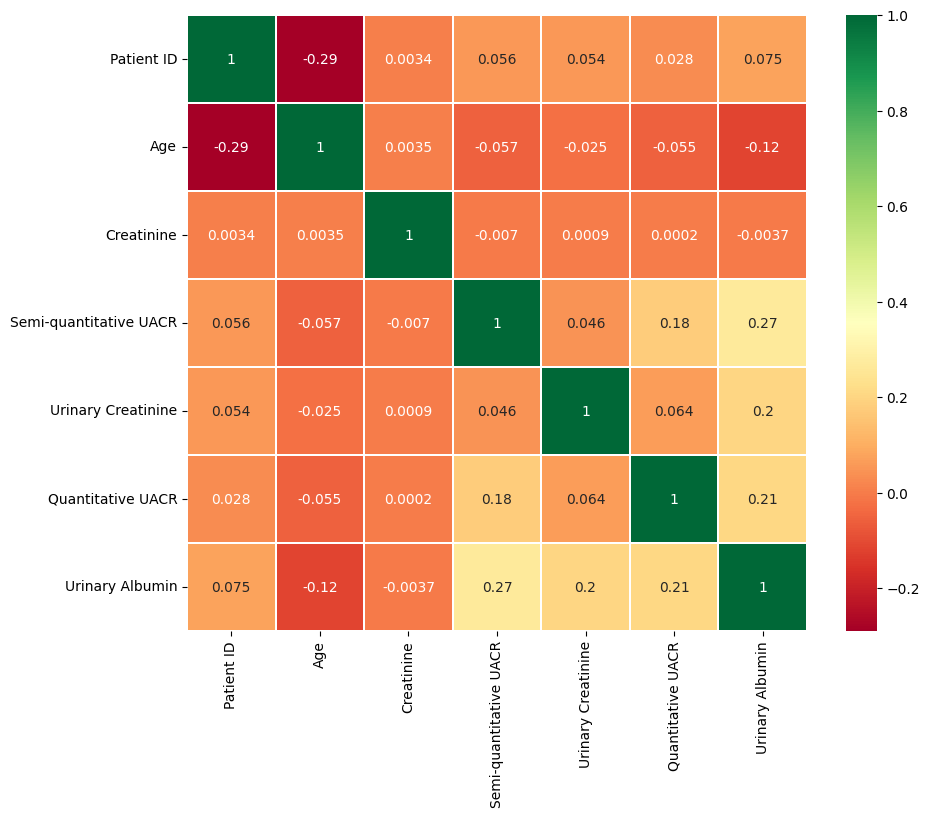

In [84]:
sns.heatmap(df_input.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

- The determinant of a patient being affected by nephropathy is when the Urinary Albumin or Quantitative UACR value is more than 300.
- Urinary Albumin and Semi-quantitative UACR are the most correlated features.
- The correlation between Urinary Creatinine or Quantitative UACR and Urinary Albumin is also high.

## **Modelling (Prediction)**

### **Split Dataset**

In [85]:
X = df_input.drop(['Name', 'Urinary Albumin', 'Age', 'Creatinine', 'Patient ID'], axis=1)
y = df_input['Urinary Albumin']

Only uses 3 features for testing, which are Semi-quantitative UACR, Quantitative UACR, and Urinary Creatinine.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=0)

In [87]:
print("Train Data:", X_train.shape[0])
print("Test Data:", X_test.shape[0])

Train Data: 395
Test Data: 99


### **Modelling and Evaluation Function**

In [88]:
def evaluation(y_test, y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  return mae, mse, rmse

def rmse_cv(model):
  rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
  return rmse

In [89]:
func = np.vectorize(lambda x: 'yes' if x > 300 else 'no')
test = func(y_test)

In [90]:
models = pd.DataFrame(columns=["Model", "Duration", "MAE", "MSE", "RMSE", "RMSE (Cross-Validation)", "Accuracy"])

### **Huber**

**Original**

In [91]:
start = time.time()
huber_ori = HuberRegressor()
huber_ori.fit(X_train, y_train)
y_pred = huber_ori.predict(X_test)
end = time.time()
duration = end - start

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(huber_ori)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

new_row = {"Model": "Huber", "Duration": duration, "MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE (Cross-Validation)": rmse_cross_val, "Accuracy": acc}
models = models.append(new_row, ignore_index=True)

MAE: 772.3338938910773
MSE: 3996079.8563965647
RMSE: 1999.0197238638154
RMSE Cross-Validation: 3255.4848699775607
Accuracy: 0.898989898989899


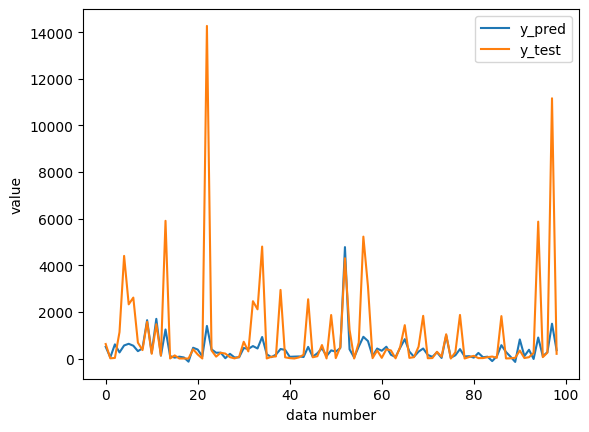

In [92]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('data number')
plt.ylabel('value')
plt.legend()
plt.show()

**Tuning**

In [93]:
start = time.time()
huber = HuberRegressor(alpha=0.1, epsilon=1.0, max_iter=100)
huber.fit(X_train, y_train)
y_pred = huber.predict(X_test)
end = time.time()
duration = end - start
dur1 = duration

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(huber)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

MAE: 715.5309167769467
MSE: 3277996.5377477803
RMSE: 1810.5238296547716
RMSE Cross-Validation: 3263.352795601272
Accuracy: 0.8585858585858586


In [94]:
params_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'epsilon': [1.0, 1.5, 2.0],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=huber, param_grid=params_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'alpha': 0.1, 'epsilon': 2.0, 'max_iter': 100}

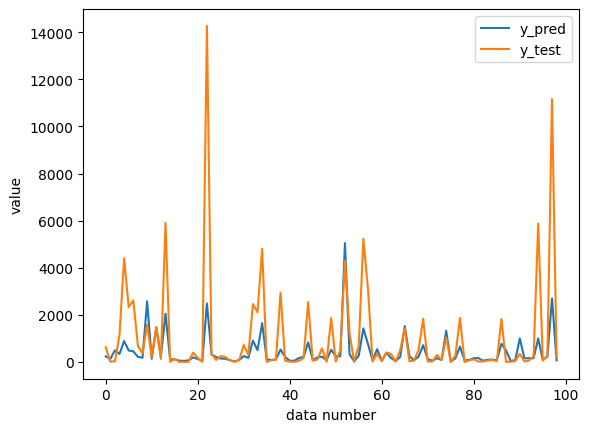

In [95]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('data number')
plt.ylabel('value')
plt.legend()
plt.show()

### **Random Forest**

**Original**

In [96]:
start = time.time()
random_forest_ori = RandomForestRegressor(random_state=0)
random_forest_ori.fit(X_train, y_train)
y_pred = random_forest_ori.predict(X_test)
end = time.time()
duration = end - start

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(random_forest_ori)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

new_row = {"Model": "RandomForestRegressor", "Duration": duration, "MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE (Cross-Validation)": rmse_cross_val, "Accuracy": acc}
models = models.append(new_row, ignore_index=True)

MAE: 281.3347515151516
MSE: 502242.5899188266
RMSE: 708.6907576078769
RMSE Cross-Validation: 976.7365178614857
Accuracy: 0.9696969696969697


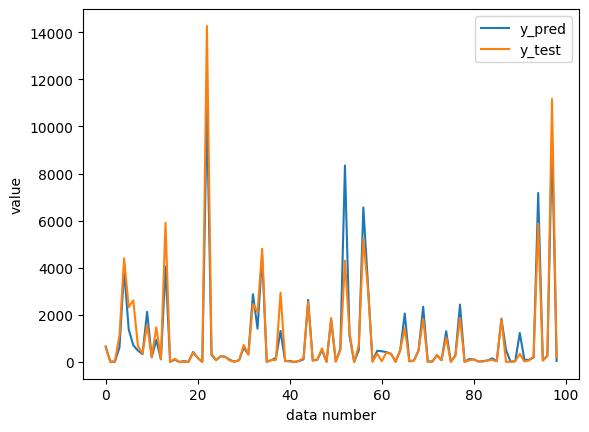

In [97]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('data number')
plt.ylabel('value')
plt.legend()
plt.show()

**Tuning**

In [98]:
start = time.time()
random_forest = RandomForestRegressor(random_state=0, n_estimators=200)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
end = time.time()
duration = end - start
dur2 = duration

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(random_forest)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

MAE: 273.863295959596
MSE: 463546.57446579123
RMSE: 680.8425474849462
RMSE Cross-Validation: 978.9636023952517
Accuracy: 0.9696969696969697


In [99]:
params_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=params_grid, cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'max_depth': 10, 'n_estimators': 200}

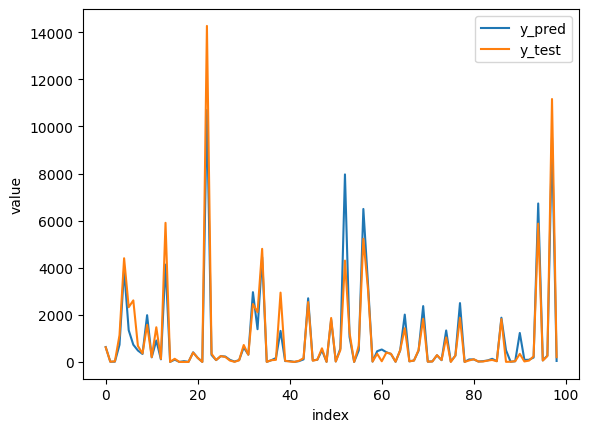

In [100]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('index')
plt.ylabel('value')
plt.legend()
plt.show()

### **CatBoost**

**Original**

In [101]:
start = time.time()
catboost_ori = CatBoostRegressor()
catboost_ori.fit(X_train, y_train)
y_pred = catboost_ori.predict(X_test)
end = time.time()
duration = end - start

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(catboost_ori)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

new_row = {"Model": "CatBoostRegressor", "Duration": duration, "MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE (Cross-Validation)": rmse_cross_val, "Accuracy": acc}
models = models.append(new_row, ignore_index=True)

Streaming output truncated to the last 5000 lines.
6:	learn: 1872.4347544	total: 6.42ms	remaining: 911ms
7:	learn: 1837.9912149	total: 7.35ms	remaining: 912ms
8:	learn: 1807.5644587	total: 8.27ms	remaining: 911ms
9:	learn: 1772.6719562	total: 9.46ms	remaining: 937ms
10:	learn: 1742.7982758	total: 10.4ms	remaining: 934ms
11:	learn: 1707.7215414	total: 11.3ms	remaining: 927ms
12:	learn: 1679.9642165	total: 12.2ms	remaining: 923ms
13:	learn: 1650.5360237	total: 13.2ms	remaining: 926ms
14:	learn: 1624.6407360	total: 14ms	remaining: 919ms
15:	learn: 1598.9079766	total: 14.9ms	remaining: 916ms
16:	learn: 1570.8664749	total: 15.9ms	remaining: 917ms
17:	learn: 1543.4553345	total: 18.6ms	remaining: 1.01s
18:	learn: 1518.5793371	total: 19.7ms	remaining: 1.02s
19:	learn: 1494.8147237	total: 21.2ms	remaining: 1.04s
20:	learn: 1469.2376071	total: 22.9ms	remaining: 1.07s
21:	learn: 1445.7290542	total: 24.8ms	remaining: 1.1s
22:	learn: 1422.4848637	total: 28.1ms	remaining: 1.19s
23:	learn: 1396.18621

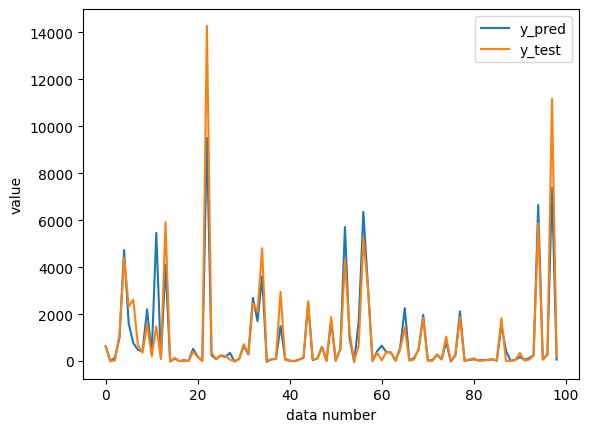

In [102]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('data number')
plt.ylabel('value')
plt.legend()
plt.show()

**Tuning**

In [103]:
start = time.time()
catboost = CatBoostRegressor(depth=4, iterations=1000, learning_rate=0.01)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
end = time.time()
duration = end - start
dur3 = duration

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(catboost)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

Streaming output truncated to the last 5000 lines.
2:	learn: 2109.9637994	total: 1.83ms	remaining: 607ms
3:	learn: 2098.1358843	total: 2.46ms	remaining: 612ms
4:	learn: 2087.4724374	total: 3.07ms	remaining: 612ms
5:	learn: 2075.5325397	total: 3.63ms	remaining: 602ms
6:	learn: 2065.9617509	total: 4.22ms	remaining: 599ms
7:	learn: 2054.1357468	total: 4.86ms	remaining: 602ms
8:	learn: 2042.7106577	total: 5.49ms	remaining: 605ms
9:	learn: 2031.5368892	total: 6.05ms	remaining: 599ms
10:	learn: 2020.3381586	total: 6.58ms	remaining: 592ms
11:	learn: 2009.3294770	total: 7.17ms	remaining: 590ms
12:	learn: 1998.7600562	total: 7.78ms	remaining: 591ms
13:	learn: 1987.4032420	total: 8.36ms	remaining: 589ms
14:	learn: 1976.9995397	total: 9.13ms	remaining: 599ms
15:	learn: 1966.6634449	total: 9.67ms	remaining: 595ms
16:	learn: 1955.5649205	total: 10.3ms	remaining: 593ms
17:	learn: 1945.4719917	total: 10.9ms	remaining: 594ms
18:	learn: 1934.6433444	total: 11.5ms	remaining: 592ms
19:	learn: 1923.559927

In [104]:
params_grid = {
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=catboost, param_grid=params_grid, cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

Streaming output truncated to the last 5000 lines.
100:	learn: 179.9357082	total: 200ms	remaining: 1.78s
101:	learn: 178.7675633	total: 202ms	remaining: 1.78s
102:	learn: 175.8832002	total: 204ms	remaining: 1.77s
103:	learn: 174.6281107	total: 205ms	remaining: 1.77s
104:	learn: 173.5697451	total: 207ms	remaining: 1.77s
105:	learn: 170.5509423	total: 209ms	remaining: 1.76s
106:	learn: 169.1332772	total: 211ms	remaining: 1.76s
107:	learn: 166.5115859	total: 213ms	remaining: 1.76s
108:	learn: 165.5218159	total: 214ms	remaining: 1.75s
109:	learn: 164.6943634	total: 216ms	remaining: 1.75s
110:	learn: 163.2720480	total: 217ms	remaining: 1.74s
111:	learn: 162.4924814	total: 222ms	remaining: 1.76s
112:	learn: 161.7494166	total: 226ms	remaining: 1.77s
113:	learn: 160.8014113	total: 230ms	remaining: 1.78s
114:	learn: 159.5512127	total: 233ms	remaining: 1.79s
115:	learn: 157.0969968	total: 236ms	remaining: 1.8s
116:	learn: 156.3040856	total: 242ms	remaining: 1.82s
117:	learn: 154.2729066	total: 2

{'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

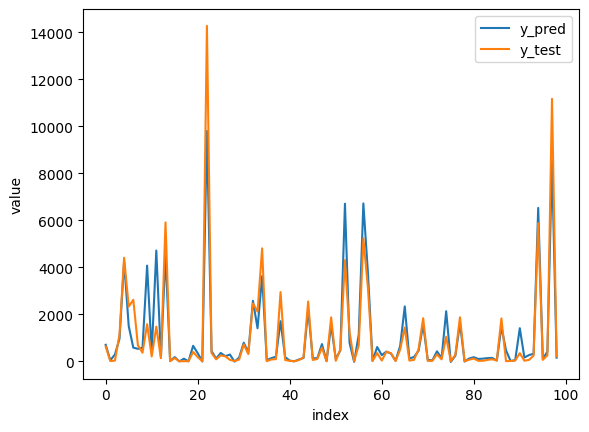

In [105]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('index')
plt.ylabel('value')
plt.legend()
plt.show()

### **Stacking Regression**
- Regressors = CatBoost and Random Forest
- Meta Regressor = Huber

In [106]:
start = time.time()
stacking = StackingRegressor(regressors=[catboost, random_forest], meta_regressor=huber)
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)
end = time.time()
duration = end - start
duration = duration + dur1 + dur2 + dur3

mae, mse, rmse = evaluation(y_test, y_pred)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
rmse_cross_val = rmse_cv(stacking)
print("RMSE Cross-Validation:", rmse_cross_val)
pred = func(y_pred)
acc = accuracy_score(test, pred)
print("Accuracy:", acc)

new_row = {"Model": "StackingRegressor", "Duration": duration, "MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE (Cross-Validation)": rmse_cross_val, "Accuracy": acc}
models = models.append(new_row, ignore_index=True)

Streaming output truncated to the last 5000 lines.
2:	learn: 2109.9637994	total: 1.21ms	remaining: 402ms
3:	learn: 2098.1358843	total: 1.55ms	remaining: 387ms
4:	learn: 2087.4724374	total: 1.88ms	remaining: 375ms
5:	learn: 2075.5325397	total: 2.21ms	remaining: 367ms
6:	learn: 2065.9617509	total: 2.64ms	remaining: 375ms
7:	learn: 2054.1357468	total: 3.28ms	remaining: 407ms
8:	learn: 2042.7106577	total: 3.88ms	remaining: 428ms
9:	learn: 2031.5368892	total: 4.91ms	remaining: 486ms
10:	learn: 2020.3381586	total: 5.71ms	remaining: 513ms
11:	learn: 2009.3294770	total: 6.49ms	remaining: 535ms
12:	learn: 1998.7600562	total: 7.31ms	remaining: 555ms
13:	learn: 1987.4032420	total: 8.16ms	remaining: 575ms
14:	learn: 1976.9995397	total: 8.88ms	remaining: 583ms
15:	learn: 1966.6634449	total: 9.65ms	remaining: 593ms
16:	learn: 1955.5649205	total: 10.5ms	remaining: 606ms
17:	learn: 1945.4719917	total: 11.4ms	remaining: 621ms
18:	learn: 1934.6433444	total: 12.1ms	remaining: 625ms
19:	learn: 1923.559927

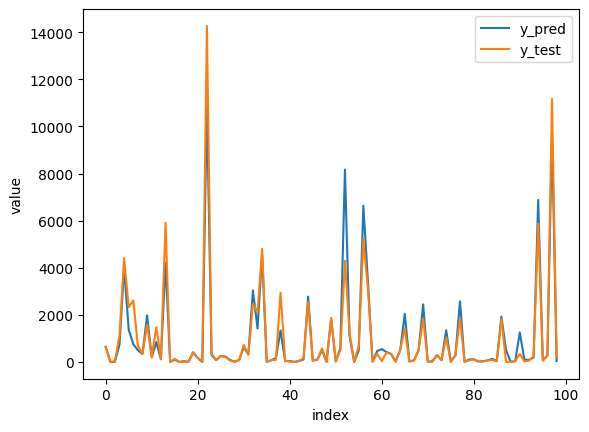

In [107]:
index = np.arange(len(y_pred))
plt.plot(index, y_pred, label='y_pred')
plt.plot(index, y_test, label='y_test')
plt.xlabel('index')
plt.ylabel('value')
plt.legend()
plt.show()

## **Evaluation**

### **Result**

In [108]:
n = len(y_test)
y_test_true = y_test.reset_index(drop=True)
errors = [y_test_true[i] - y_pred[i] for i in range(n)]
squared_errors = [error**2 for error in errors]
mean_squared_error = sum(squared_errors) / n
rmse = np.sqrt(mean_squared_error)
print(f'RMSE: {rmse}')

RMSE: 677.7762426322765


The result of manual calculation is the same as the library.

In [109]:
mae = models.sort_values(by="MAE").reset_index(drop=True)
mse = models.sort_values(by="MSE").reset_index(drop=True)
rmse = models.sort_values(by="RMSE").reset_index(drop=True)
rmsecv = models.sort_values(by="RMSE (Cross-Validation)").reset_index(drop=True)
acc = models.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

mods = np.array(models['Model'])
scores = []

def score(df):
  for mod in mods:
    score = 0
    index = mae[mae['Model'] == mod].index
    score += index
    index = mse[mse['Model'] == mod].index
    score += index
    index = rmse[rmse['Model'] == mod].index
    score += index
    index = rmsecv[rmsecv['Model'] == mod].index
    score += index
    index = acc[acc['Model'] == mod].index
    score += index
    scores.append(score)

score(models)
models['Score'] = pd.DataFrame(scores)
models['Rank'] = models['Score'].rank().astype(int)
models.sort_values(by="Rank").reset_index(drop=True)

,Model,Duration,MAE,MSE,RMSE,RMSE (Cross-Validation),Accuracy,Score,Rank
0,StackingRegressor,3.145695,275.166230,4.593806e+05,677.776243,986.841500,0.979798,2,1
1,RandomForestRegressor,0.460243,281.334752,5.022426e+05,708.690758,976.736518,0.969697,4,2
2,CatBoostRegressor,1.206986,319.883989,7.190922e+05,847.993021,981.968853,0.929293,9,3
3,Huber,0.047502,772.333894,3.996080e+06,1999.019724,3255.484870,0.898990,15,4


Stacking Regressor is the best model compared to other models (with tuning).

### **Models Evaluation Sort by RMSE (Cross-Validation)**

In [110]:
models.sort_values(by="RMSE (Cross-Validation)").reset_index(drop=True)

,Model,Duration,MAE,MSE,RMSE,RMSE (Cross-Validation),Accuracy,Score,Rank
0,RandomForestRegressor,0.460243,281.334752,5.022426e+05,708.690758,976.736518,0.969697,4,2
1,CatBoostRegressor,1.206986,319.883989,7.190922e+05,847.993021,981.968853,0.929293,9,3
2,StackingRegressor,3.145695,275.166230,4.593806e+05,677.776243,986.841500,0.979798,2,1
3,Huber,0.047502,772.333894,3.996080e+06,1999.019724,3255.484870,0.898990,15,4


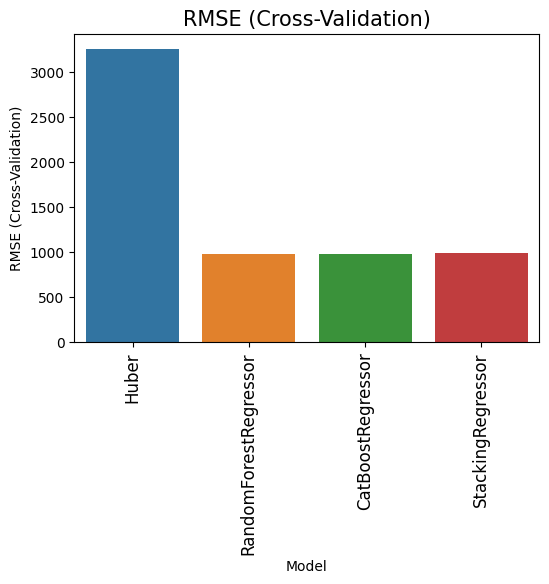

In [111]:
plt.figure(figsize=(6,4))
sns.barplot(x=models["Model"], y=models["RMSE (Cross-Validation)"])
plt.title("RMSE (Cross-Validation)", size=15)
plt.xticks(rotation=90, size=12)
plt.show()

Random Forest has the lowest RMSE (Cross-Validation) compared to other models.

### **Models Evaluation Sort by Accuracy**

In [112]:
models.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

,Model,Duration,MAE,MSE,RMSE,RMSE (Cross-Validation),Accuracy,Score,Rank
0,StackingRegressor,3.145695,275.166230,4.593806e+05,677.776243,986.841500,0.979798,2,1
1,RandomForestRegressor,0.460243,281.334752,5.022426e+05,708.690758,976.736518,0.969697,4,2
2,CatBoostRegressor,1.206986,319.883989,7.190922e+05,847.993021,981.968853,0.929293,9,3
3,Huber,0.047502,772.333894,3.996080e+06,1999.019724,3255.484870,0.898990,15,4


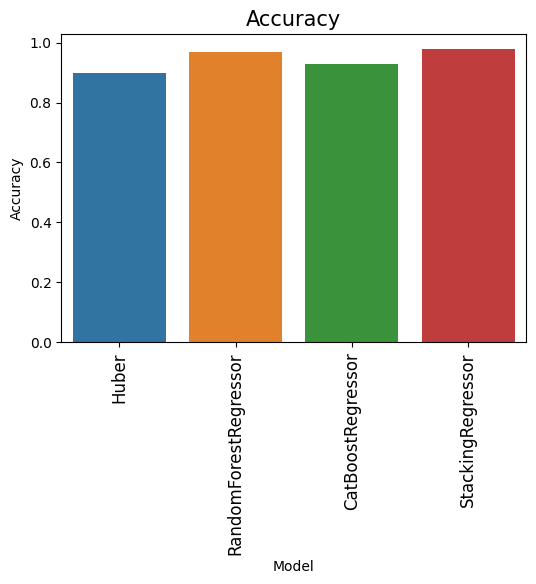

In [113]:
plt.figure(figsize=(6,4))
sns.barplot(x=models["Model"], y=models["Accuracy"])
plt.title("Accuracy", size=15)
plt.xticks(rotation=90, size=12)
plt.show()

Stacking Regressor has the highest accuracy compared to other models.

### **Feature Importance in Each Models**

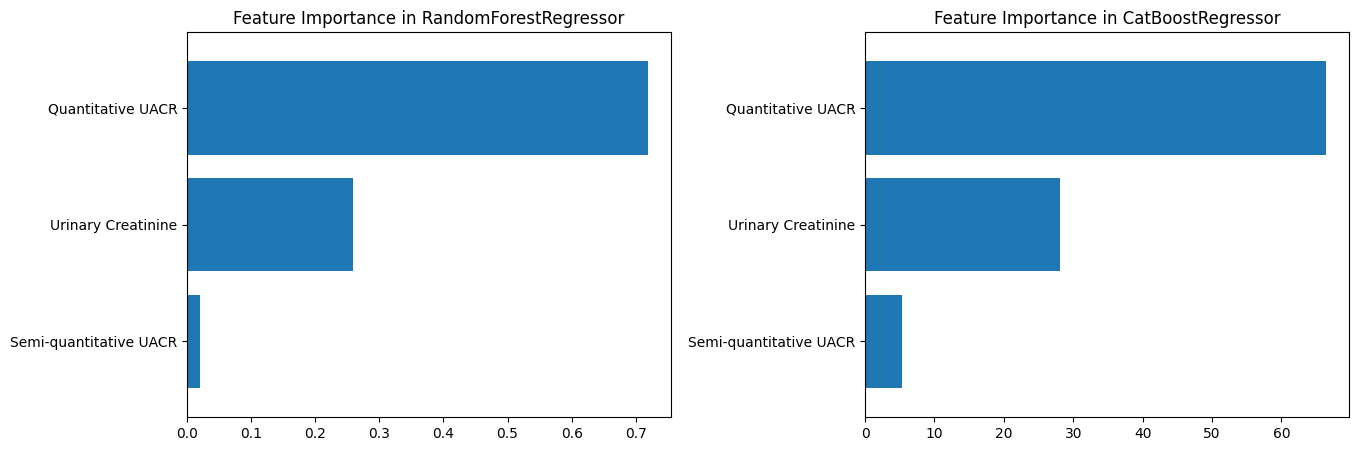

In [114]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)
pd.Series(random_forest.feature_importances_, X.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=ax[0])
ax[0].set_title('Feature Importance in RandomForestRegressor')
pd.Series(catboost.feature_importances_, X.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=ax[1])
ax[1].set_title('Feature Importance in CatBoostRegressor')
plt.show()

Random Forest and CatBoost have the same feature importance order, which are Quantitative UACR, Urinary Creatinine, and Semi-quantitative UACR.